In [1]:
import sys
import os
sys.path.append(f'{os.path.dirname(os.getcwd())}/utils')
from data_util import (download_data_local_check, prep_stock_data, prep_fx_data, calc_sharpe)

In [2]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import (train_test_split,  
                                     KFold, 
                                     cross_val_score,
                                     cross_val_predict,
                                    )
from datetime import datetime, timedelta, time
import plotly.graph_objects as go
import sklearn.metrics as metrics
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import scikitplot as skplt
import xgboost as xgb
import pandas as pd
import numpy as np
import talib
import time
import os

C:\Users\Jameshuckle\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 
pd.options.display.max_rows= 1000
pd.options.display.max_columns= 1000

In [4]:
data_source = 'stock' # 'fx', 'stock'

if data_source == 'fx':
    ### FX data #######
    fx_files = [
                 'EURUSD_1h_2003-2020.csv',
                 'GBPUSD_1h_2003-2020.csv',
                 'USDJPY_1h_2003-2020.csv',
                 'NZDUSD_1h_2003-2020.csv',
                 'AUDUSD_1h_2003-2020.csv',
                 'USDCAD_1h_2003-2020.csv',
                 'USDCHF_1h_2003-2020.csv',
                 ]

    loaded_files = prep_fx_data(fx_files)
        
if data_source == 'stock':
    ### stock data ######
    start = '2000-01-01'
    end = '2020-11-1'
    ## download data
    all_stock_data = download_data_local_check('SP500', start, end)
    loaded_files = prep_stock_data(all_stock_data, filter_start_date_tuple=None,
                                   volume=False) #(2015,1,1)

data already saved C:\Users\Jameshuckle\Dropbox\My-Portfolio\AlgorithmicTrading/data/SP500_all_stock_data_2000-01-01-2020-11-1.csv
num stocks: 505
WY has moves that are too large
AAPL has moves that are too large
APA has moves that are too large
BRK.B does not have enough data
EXPE has moves that are too large
WMB has moves that are too large
VNT does not have enough data
BF.B does not have enough data
JCI has moves that are too large
UA has moves that are too large
AIG has moves that are too large
HIG has moves that are too large
MO has moves that are too large
PWR has moves that are too large
STT has moves that are too large
KSU has moves that are too large
OXY has moves that are too large
REGN has moves that are too large
ROK has moves that are too large


In [5]:
def ohlc_diff(data):
    prev_close = data['close'].shift(1)
    for col in ['open', 'high', 'low', 'close']:
        data[f'ohlc_diff_{col}'] = (data[col] - prev_close) / prev_close
        data.loc[data.index.values[0], f'ohlc_diff_{col}'] = 0
    data.dropna(inplace=True)
    return data


def add_opposite_bars(loaded_files, var):
    already_done = any(['opposite' in inst for inst in loaded_files.keys()])
    if already_done:
        print('already done opposite bars')
        return
    
    new_data = {}
    for inst, data in loaded_files.items():
        data = data.copy()
        if 'Volume' in data.columns:
            data.drop('Volume', axis='columns', inplace=True)
        data = data[data.index < var.train_split[1]]
        if len(data) < 100:
            continue
        cols = ['open','high','low','close']
        data.columns = cols
        data = ohlc_diff(data)
        data['close_opp'] = ((data['ohlc_diff_close'] * -1) + 1).cumprod() * data['close'][0]
        prev_close = data['close_opp'].shift(1)
        data['open_opp'] = ((data['ohlc_diff_open'] * -1) + 1) * prev_close
        data['low_opp'] = ((data['ohlc_diff_high'] * -1) + 1) * prev_close
        data['high_opp'] = ((data['ohlc_diff_low'] * -1) + 1) * prev_close
        opposite_bars = data[['open_opp','high_opp','low_opp','close_opp']]
        opposite_bars.columns = cols
        opposite_bars.loc[opposite_bars.index.values[0], :] = data[cols].values[0]
        new_data[f'opp-{inst}'] = opposite_bars
    loaded_files.update(new_data)


def add_ma_smooth(data, cols, ma_smooth, ma_smooth_diff=False):
    for col in cols:
        data[f'ma_smooth_{col}'] = data[col].rolling(window=ma_smooth).mean()
        if var.ma_smooth_diff:
            data[f'ma_smooth_{col}'] = data[f'ma_smooth_{col}'].pct_change()
    data.dropna(inplace=True)
    return data


def normalize_bars(data, cols, col_to_norm='ohlc_diff', norm_ma=1000):
    for col in cols:
        mins = data[f'{col_to_norm}{col}'].rolling(window=norm_ma, min_periods=100).min()
        maxs = data[f'{col_to_norm}{col}'].rolling(window=norm_ma, min_periods=100).max()
        means = data[f'{col_to_norm}{col}'].rolling(window=norm_ma, min_periods=100).mean()
        ranges = maxs - mins
        #data[col] = (data[col] - mins) / ranges
        data[f'norm_{col_to_norm}{col}'] = (data[f'{col_to_norm}{col}'] - means) / ranges
        data[f'norm_{col_to_norm}{col}'].replace([np.inf, -np.inf], 0, inplace=True)
    data.dropna(inplace=True)
    return data


def sliding_window_data(data, cols_to_shift, window, timestep):
    # create window data
    for win in range(window):
        for i, col in enumerate(cols_to_shift):
            row_idx = win * len(cols_to_shift) # num_cols
            data[str(row_idx + i)] = data[col].shift(-win)
    return data


def window_labels(data, window, timestep, data_percentage_diff):
    # add time step labels
    label_bar = data['close'].shift(-((window - 1) + timestep))
    if data_percentage_diff == False:
        data['num_bars_label'] = label_bar
    elif data_percentage_diff == 'close_diff':
        last_bar = data['close'].shift(-(window - 1))
        data['num_bars_label'] = (label_bar - last_bar) / last_bar
    return data


def create_sliding_window(data, main_col, var):
    cols_to_shift = [f'{main_col}{col}' for col in var.cols]
    data = sliding_window_data(data, cols_to_shift, var.window, var.num_bars)
    data = window_labels(data, var.window, var.num_bars, var.data_percentage_diff)
    return data


def rolling_bar_volatility(data, ma=100):
    bar_high_low = data['high'] - data['low']
    bar_high_low_pct_diff = bar_high_low / data['high']
    roll_avg_bar_pct_size = (bar_high_low_pct_diff.rolling(window=ma, min_periods=0).mean()
                            .reset_index(drop=True))
    roll_avg_bar_pct_size = np.array(roll_avg_bar_pct_size)
    return roll_avg_bar_pct_size


def triple_barrier(data, window=1, bar_horizon=1000, bar_size_ma=100, target_stop_size=3,
                   target_stop_type='high_low', problem_type='binary', just_labels=False):

    last_bars = data['close'].shift(-(window - 1))
    roll_avg_bar_pct_size = rolling_bar_volatility(data, ma=bar_size_ma)
    child_pct = roll_avg_bar_pct_size * target_stop_size
    child_distance = last_bars * child_pct
    target_series = last_bars + child_distance
    stop_series = last_bars - child_distance

    if target_stop_type == 'high_low':
        highs = data['high'].to_numpy()
        lows = data['low'].to_numpy()
        opens = data['open'].to_numpy()
    elif target_stop_type == 'close':
        highs = lows = data['close'].to_numpy()
        opens = data['open'].to_numpy()
    else:
        raise Exception('target_stop_type not recognised!')
        
    closes = data['close'].to_numpy()
    targets = target_series.to_list()
    stops = stop_series.to_list()

    not_hit_target_or_stop = 0
    hit_target_and_stop = 0
    gap_stop = 0
    gap_target = 0
    labels = []
    for idx in range(len(closes)):
        if idx == (len(closes) - window):
            labels.append([np.nan, closes[-1], 'neither'])
            break

        last_bar = last_bars[idx]
        target = targets[idx]
        stop = stops[idx]
        start_idx = (window - 1) + idx + 1
        future_highs = highs[start_idx: start_idx + bar_horizon]
        future_lows = lows[start_idx: start_idx + bar_horizon]
        future_closes = closes[start_idx: start_idx + bar_horizon]
        future_opens = opens[start_idx: start_idx + bar_horizon]
        
        larger_than_target = future_highs > target
        target_idx = None if larger_than_target.sum() == 0 else larger_than_target.argmax()
        smaller_than_stop = future_lows < stop
        stop_idx = None if smaller_than_stop.sum() == 0 else smaller_than_stop.argmax()

        if target_idx == None and stop_idx == None:
            # manual exit at end of bar horizon
            not_hit_target_or_stop += 1
            fraction_target_stop = (future_closes[-1] - last_bar) / child_distance[idx]
            labels.append([fraction_target_stop, future_closes[-1], 'neither'])
        elif target_idx == None:
            labels.append([-1, stop, 'stop'])
        elif stop_idx == None:
            labels.append([1, target, 'target'])
        elif stop_idx < target_idx:
            if future_opens[stop_idx] < stop:
                gap_stop += 1
                fraction_target_stop = (future_opens[stop_idx] - last_bar) / child_distance[idx]
                labels.append([fraction_target_stop, future_opens[stop_idx], 'target'])
            else:
                labels.append([-1, stop, 'stop'])
        elif target_idx < stop_idx:
            if future_opens[target_idx] > target:
                gap_target += 1
                fraction_target_stop = (future_opens[target_idx] - last_bar) / child_distance[idx]
                labels.append([fraction_target_stop, future_opens[stop_idx], 'stop'])
            else:
                labels.append([1, target, 'target'])
        elif target_idx == stop_idx:
            hit_target_and_stop += 1
            random_side =  np.random.choice([0,1])
            if random_side == 0:
                labels.append([-1, stop, 'rand_stop'])
            else:
                labels.append([1, target, 'rand_target'])
        else:
            raise Exception('stop or target not recognised, bug!')
       
    print(f'# trades not hit target or stop: {not_hit_target_or_stop}')
    print(f'# trades hit both target and stop: {hit_target_and_stop}')
    print(f'# trades gapped stop: {gap_stop} | # trades gapped target: {gap_target}')
    
    for _ in range(window - 1):
        labels.append([np.nan, closes[-1], 'end of data'])
        
    target_stops = pd.DataFrame(labels, columns=['perc_target_stop',
                                                 'price_target_stop',
                                                 'target_stop_class'])
    target_stops.index = data.index
    data['perc_target_stop'] = target_stops['perc_target_stop']
    if not just_labels:
        data['last_bar'] = last_bars
        data['child_pct'] = child_pct
        data['child_dist'] = child_distance
        data['target_level'] = target_series
        data['stop_level'] = stop_series
        data['price_target_stop'] = target_stops['price_target_stop']
        data['target_stop_class'] = target_stops['target_stop_class']
        
    if problem_type == 'binary':
        data['target'] = (target_stops['perc_target_stop'] >= 0).astype(int) 
        print('dropping trades that did not meet a target or stop!')
        #data = data[target_stops['target_stop_class'].isin(['stop', 'target'])]
    elif problem_type == 'category':
        data = data[target_stops['target_stop_class'].isin(['stop', 'target', 'neither'])]
        hit_target = target_stops['target_stop_class'] == 'target'
        hit_stop = target_stops['target_stop_class'] == 'stop'
        hit_neither = target_stops['target_stop_class'] == 'neither'
        data.loc[hit_target, 'target'] = 2
        data.loc[hit_stop, 'target'] = 0
        data.loc[hit_neither, 'target'] = 1
    return data


def plot_target_stop(data, var, bars, start_idx, v_line_delta, h_line_price):
    # only plots HOURLY price data currently
    cols = ['open', 'high', 'low', 'close']
    plot_frame = data[cols + ['stop_level', 'target_level', 'perc_target_stop']].copy()
    for col in var.cols:
        plot_frame[f'last_{col}'] = plot_frame[col].shift(-(var.window - 1))
    
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12,6), gridspec_kw={'height_ratios': [3, 1]})
    plt.subplots_adjust(wspace=0, hspace=0)
    
    plot_cols = [f'last_{col}' for col in cols]
    plot_frame[plot_cols + ['stop_level', 'target_level']][start_idx:start_idx+bars].plot(
        ax=ax[0], style=['g','grey','grey','r','k--','k--'])
    v_line_idx = plot_frame[start_idx:start_idx+bars].index[0] + v_line_delta
    ax[0].axvline(v_line_idx, c='k', linewidth=1)
    ax[0].axhline(h_line_price, c='k', linewidth=1)
    
    data['perc_target_stop'][start_idx:start_idx+bars].plot(ax=ax[1])
    ax[1].axvline(v_line_idx, c='k', linewidth=1)
    plt.show()
    return plot_frame[start_idx:start_idx+bars]


def create_dataset(loaded_files, var):
    final_data = []
    for i, (inst, data) in enumerate(loaded_files.items()):
        print(i, inst)
        
        
        if i > var.num_instruments:
            opps = [x for x in loaded_files.keys() if 'opp-' in x][:var.num_instruments]
            if inst not in opps:
                continue
            
        if len(data) < (var.window + 100):
            print(f'{inst} not enough data')
            continue
            
        data = data.copy()
        if 'Volume' in list(data.columns):
            data.drop('Volume', axis=1, inplace=True)
        cols = ['open', 'high', 'low', 'close']
        data.columns = cols
        if var.resample:
            data = data.resample(var.resample).agg({'open':'first','high':'max',
                                                    'low':'min','close':'last'})
            data = data.ffill()
            
        main_col = ''
        data = ohlc_diff(data)
        if var.data_percentage_diff:
            main_col = 'ohlc_diff_'            
        if var.ma_smooth:
            data = add_ma_smooth(data, var.cols, var.ma_smooth)
            main_col = 'ma_smooth'
        if var.standardize:
            data = normalize_bars(data, var.cols, col_to_norm=main_col, norm_ma=var.norm_ma)
            main_col = f'norm_{main_col}'
        #data = create_sliding_window(data, main_col, var)
        
        if var.target_stop:
            data = triple_barrier(data, var.window, var.bar_horizon, var.bar_size_ma,
                                  var.target_stop_size, var.target_stop_type,
                                  var.problem_type, just_labels=False)
        data.dropna(inplace=True)
        data['inst'] = inst.split('_')[0]
        final_data.append(data)
        
    if len(final_data) == 0:
        print('no data found!')
        return []
    else:
        data = pd.concat(final_data, axis=0)
        data.sort_index(inplace=True)
        return data

In [6]:
class algo_variables():
    pass

experiment_path = f'B:/Algo_Trading'
var = algo_variables()
var.cols = ['open', 'high', 'low', 'close'] #['close'] #['open', 'high', 'low', 'close']
var.opposite_bars = False
var.upsample_classes = False
var.num_instruments = 10
var.ma_smooth = False #100, False  # create ma of prices
var.ma_smooth_diff = False 
var.data_percentage_diff = 'close_diff' #'close_diff' False
var.window = 300
var.standardize = 'min_max' # 'min_max' False
var.norm_ma = 10000 # running window of min_max of bars to normalize bars
var.train_split = (
    datetime(2016,1,1), # validation
    datetime(2018,1,1), # test
)
var.resample = '1D' # None '1D', '4H', '1W'

var.num_bars = 30 # prediction horizon
var.problem_type = 'binary' #'regression' 'binary' 'category'

## target/stop binary outcomes (1 R/R) ##
var.target_stop = True
if var.target_stop:
    var.num_bars = 1
    var.target_stop_type = 'high_low' #'high_low', 'close'
    var.bar_horizon = 1000 # how long to wait for stop or target hit, otherwise assign current profit
    var.bar_size_ma = 100 # how long is moving average for bar size (used to calc stop and target)
    var.target_stop_size = 2 # size of stop and target relative to averge bar size
    
var.embeddings = False
# var.embedding_type = None #None 'light'
# if var.embeddings:
#     var.standardize = False 
#     var.pca_features = False
#     var.vector_size = 200 # 200, 4
#     if var.embedding_type == 'light':
#         var.vector_size = 1

##
var.input_len = var.window * len(var.cols)
##

generator = False
train_dataset, test_dataset = [], []
# if generator: 
#     ## save all stocks to csv and tfrecords, then load tfrecords as dataset
#     var.train_validation = 0.8 #False # Uses traning data to create test set (for validation)
#     var.batch_size = 500
#     base_path = f'C:/Users/Jameshuckle/Documents/Algo_Trading/data'
#     save_numpy_to_csv_all_files(base_path, var)
#     train_dataset = create_tfrecord_dataset(f'{base_path}/all_data_train', var)
#     test_dataset = create_tfrecord_dataset(f'{base_path}/all_data_test', var)
# else:
#     ### load single stock into numpy
#     (x, y, x_test, y_test, y_pct_diff, y_test_pct_diff, train_data_raw,
#      test_data_raw) = create_dataset(file_name=list(loaded_files.keys())[0], var=var)
#     train_dataset, test_dataset = [], []

if var.opposite_bars:
    add_opposite_bars(loaded_files, var)
###############################   
data = create_dataset(loaded_files, var)

0 AMAT
# trades not hit target or stop: 2
# trades hit both target and stop: 5
# trades gapped stop: 416 | # trades gapped target: 469
dropping trades that did not meet a target or stop!
1 ALK
# trades not hit target or stop: 1
# trades hit both target and stop: 9
# trades gapped stop: 238 | # trades gapped target: 283
dropping trades that did not meet a target or stop!
2 CTAS
# trades not hit target or stop: 2
# trades hit both target and stop: 25
# trades gapped stop: 412 | # trades gapped target: 348
dropping trades that did not meet a target or stop!
3 EVRG
# trades not hit target or stop: 2
# trades hit both target and stop: 66
# trades gapped stop: 370 | # trades gapped target: 307
dropping trades that did not meet a target or stop!
4 V
# trades not hit target or stop: 0
# trades hit both target and stop: 8
# trades gapped stop: 183 | # trades gapped target: 213
dropping trades that did not meet a target or stop!
5 XOM
# trades not hit target or stop: 0
# trades hit both target a

In [7]:
import inspect
import ast

def search_docstring(docstring, search_word):
    doc_list = docstring.split('\n\n')
    filter_str = [row for row in doc_list if 'Inputs' in row]
    if len(filter_str) == 0:
        None #return []
    rows = [r.strip(' ') for r in filter_str[0].split('\n')]
    filter_word = [r for r in rows if r == f'{search_word}:'][0]
    filter_word_idx = rows.index(filter_word)
    result = rows[filter_word_idx + 1]
    if 'prices: ' in result:
        result = ast.literal_eval(result.strip('prices: '))
    return result

def add_all_talib_indicators(ind_data):
    func_names = talib.__TA_FUNCTION_NAMES__
    for func_name in func_names:
        func = getattr(talib, func_name)
        print(func)
        docstring = func.__doc__

        inputs = search_docstring(docstring, 'Inputs')
        price_inputs = [i for i in inputs if i in ['open', 'high', 'low', 'close']]
        if len(price_inputs) > 0:
            func_inputs = {p:data[p] for p in price_inputs}
            try:
                indicators = func(**func_inputs)
                if isinstance(indicators, tuple):
                    for i, ind in enumerate(indicators):
                        ind_data[f'{func_name}_{i}'] = ind
                else:
                    ind_data[f'{func_name}'] = indicators
            except:
                None
    return ind_data

ind_data = pd.DataFrame()
ind_data = add_all_talib_indicators(ind_data)

<function ACOS at 0x00000173053A24C8>
<function AD at 0x000001730C1254C8>
<function ADD at 0x000001730C125558>
<function ADOSC at 0x000001730C1255E8>
<function ADX at 0x000001730C125678>
<function ADXR at 0x000001730C125708>
<function APO at 0x000001730C125798>
<function AROON at 0x000001730C125828>
<function AROONOSC at 0x000001730C1258B8>
<function ASIN at 0x000001730C125948>
<function ATAN at 0x000001730C1259D8>
<function ATR at 0x000001730C125A68>
<function AVGPRICE at 0x000001730C125AF8>
<function BBANDS at 0x000001730C125B88>
<function BETA at 0x000001730C125C18>
<function BOP at 0x000001730C125CA8>
<function CCI at 0x000001730C125D38>
<function CDL2CROWS at 0x000001730C125DC8>
<function CDL3BLACKCROWS at 0x000001730C125E58>
<function CDL3INSIDE at 0x000001730C125EE8>
<function CDL3LINESTRIKE at 0x000001730C125F78>
<function CDL3OUTSIDE at 0x000001730C132048>
<function CDL3STARSINSOUTH at 0x000001730C1320D8>
<function CDL3WHITESOLDIERS at 0x000001730C132168>
<function CDLABANDONE

In [8]:
def high_low_index(close):
    high_52 = (close.rolling(window=250, min_periods=0).max() == close).rolling(
        window=250, min_periods=0).sum()
    low_52 = (close.rolling(window=250, min_periods=0).min() == close).rolling(
        window=250, min_periods=0).sum()
    high_low_idx = high_52 / (high_52 + low_52)
    return high_low_idx

def bull_bear_power(high, low, close):
    bull_power = high - talib.EMA(close, timeperiod=13)
    bear_power = talib.EMA(close, timeperiod=13) - low
    return bull_power, bear_power

In [9]:
from functools import partial
cut = partial(pd.cut, include_lowest=True)

o = data['open']
h = data['high']
l = data['low']
c = data['close']

In [10]:
ind_data = pd.DataFrame()

ind_data['rsi'] = talib.RSI(c, 14)
ind_data['stoch'], ind_data['stochd'] = talib.STOCH(h, l, c, fastk_period=9, slowk_period=6)
ind_data['stochrsi'], ind_data['stochrsid'] = talib.STOCHRSI(c)
ind_data['macd'], ind_data['macdsignal'], ind_data['macdhist'] = talib.MACD(c)
ind_data['adx'] = talib.ADX(h, l, c, timeperiod=14)
ind_data['high_low_idx'] = high_low_index(c)
ind_data['ultosc'] = talib.ULTOSC(h, l, c)
ind_data['roc'] = talib.ROC(c)
ind_data['willr'] = talib.WILLR(h, l, c, timeperiod=14)
ind_data['bull_power'], ind_data['bear_power'] = bull_bear_power(h, l, c)

for ma in [5, 10, 20, 50, 100, 200]:
    ind_data[f'ma{ma}'] = c.rolling(window=ma).mean()
    ind_data[f'ema{ma}'] = talib.EMA(c, timeperiod=ma)
    
patterns = talib.__function_groups__['Pattern Recognition']
for col in ind_data.columns:
    if col in patterns:
        continue
    ind_data[f'{col}_diff'] = ind_data[col].pct_change()
   

bucket_ind_data = False
if bucket_ind_data:
    bins = [0,30,50,70,np.inf]
    labels = [1,2,3,4]
    ind_data['rsi'] = cut(ind_data['rsi'], bins=bins, labels=labels).astype(float)

    bins = [0,20,50,80,np.inf]
    labels = [1,2,3,4]
    ind_data['stoch'] = cut(ind_data['stoch'], bins=bins, labels=labels).astype(float)
    ind_data['stochd'] = cut(ind_data['stochd'], bins=bins, labels=labels).astype(float)

    bins = [0,20,50,80,np.inf]
    labels = [1,2,3,4]
    ind_data['stochrsi'] = cut(ind_data['stochrsi'], bins=bins, labels=labels).astype(float)
    ind_data['stochrsid'] = cut(ind_data['stochrsid'], bins=bins, labels=labels).astype(float)

    bins = [-np.inf,0,np.inf]
    labels = [1,2]
    ind_data['macdhist'] = cut(ind_data['macdhist'], bins=bins, labels=labels).astype(float)
    ind_data['macd'] = (ind_data['macdsignal'] >= ind_data['macd']).astype(int)

    bins = [0,25,50,75,np.inf]
    labels = [1,2,3,4]
    ind_data['adx'] = cut(ind_data['adx'], bins=bins, labels=labels).astype(float)

    bins = [0,0.2,0.5,0.8,np.inf]
    labels = [1,2,3,4]
    ind_data['high_low_idx'] = cut(ind_data['high_low_idx'], bins=bins, labels=labels).astype(float)

    bins = [0,30,50,70,np.inf]
    labels = [1,2,3,4]
    ind_data['ultosc'] = cut(ind_data['ultosc'], bins=bins, labels=labels).astype(float)

    bins = [-np.inf,0,np.inf]
    labels = [1,2]
    ind_data['roc'] = cut(ind_data['roc'], bins=bins, labels=labels).astype(float)

    bins = [-100,-80,-50,-20,1]
    labels = [1,2,3,4]
    ind_data['willr'] = cut(ind_data['willr'], bins=bins, labels=labels).astype(float)

    ind_data['bull_power'] = (ind_data['bull_power'] > 0).astype(int)
    ind_data['bear_power'] = (ind_data['bear_power'] > 0).astype(int)
    
    for ma in [5, 10, 20, 50, 100, 200, 500, 1000]:
        ind_data[f'ma{ma}'] = (ind_data[f'ma{ma}'].pct_change() > 0).astype(int)
        ind_data[f'ema{ma}'] = (ind_data[f'ema{ma}'].pct_change() > 0).astype(int)
        
    for col in ind_data.columns:
        ind_data[col] = (ind_data[col] > 0).astype(int)

all_data = ind_data
all_data = all_data.ffill()
all_data['target'] = data['target']
all_data['perc_target_stop'] = data['perc_target_stop']
#all_data.dropna(inplace=True, axis=1, how='all')
all_data.dropna(inplace=True, axis=0)
all_data.head()

,rsi,stoch,stochd,stochrsi,stochrsid,macd,macdsignal,macdhist,adx,high_low_idx,ultosc,roc,willr,bull_power,bear_power,ma5,ema5,ma10,ema10,ma20,ema20,ma50,ema50,ma100,ema100,ma200,ema200,rsi_diff,stoch_diff,stochd_diff,stochrsi_diff,stochrsid_diff,macd_diff,macdsignal_diff,macdhist_diff,adx_diff,high_low_idx_diff,ultosc_diff,roc_diff,willr_diff,bull_power_diff,bear_power_diff,ma5_diff,ema5_diff,ma10_diff,ema10_diff,ma20_diff,ema20_diff,ma50_diff,ema50_diff,ma100_diff,ema100_diff,ma200_diff,ema200_diff,target,perc_target_stop
Gmt time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-05-06,54.901409,51.015627,55.310023,100.000000,33.333333,0.638703,0.085928,0.552775,6.553016,0.083333,53.559966,586.315789,-1.133948,22.014056,-20.701556,27.93125,31.163049,29.565625,29.750292,29.424219,29.034302,28.260938,28.667089,28.788281,28.503636,28.010156,28.245096,0.218084,-0.000005,-0.062649,inf,0.967195,-1.428268,-2.644075,-1.384112,0.070663,0.0,0.129535,-22.222082,-0.988612,-2.212878,-2.123161,0.089734,0.464716,0.172585,0.188015,0.006306,0.086259,0.000022,0.032747,0.015342,0.016157,-0.000245,0.008140,0,-1.0
2000-05-06,52.234408,51.009189,51.013570,72.867328,57.622443,1.382900,0.345323,1.037578,6.522914,0.083333,49.435011,154.435484,-27.214741,9.145977,-6.645977,30.49375,33.921199,31.959375,31.511603,29.458594,30.025083,28.835938,29.089458,28.787656,28.720148,28.130469,28.356463,-0.048578,-0.000126,-0.077679,-0.271327,0.728673,1.165170,3.018732,0.877035,-0.004594,0.0,-0.077016,-0.736600,23.000000,-0.584539,-0.678962,0.091743,0.088507,0.080964,0.059203,0.001168,0.034124,0.020346,0.014734,-0.000022,0.007596,0.004295,0.003943,1,1.0
2000-05-06,46.088675,44.750312,48.925042,10.343871,61.070400,-0.388118,0.198635,-0.586752,6.467058,0.083333,43.222918,0.000000,-93.692417,-17.486484,17.798984,24.60625,25.989133,31.959375,27.623129,28.164844,28.129837,28.475938,28.345754,28.508281,28.351927,27.975469,28.175055,-0.117657,-0.122701,-0.040941,-0.858045,0.059837,-1.280655,-0.424786,-1.565502,-0.008563,0.0,-0.125662,-1.000000,2.442708,-2.911932,-3.678159,-0.193072,-0.233838,0.000000,-0.123398,-0.043918,-0.063122,-0.012484,-0.025566,-0.009705,-0.012821,-0.005510,-0.006397,0,-1.0
2000-05-06,47.201294,35.446566,43.735356,21.663079,34.958093,-1.382356,-0.117564,-1.264792,6.245810,0.083333,48.347562,-62.500000,-82.636428,-10.425915,11.050915,24.60625,22.326089,29.459375,25.328015,28.402344,26.879376,28.460938,27.822391,28.377656,28.087533,27.852031,28.043960,0.024141,-0.207903,-0.106074,1.094291,-0.427577,2.561691,-1.591858,1.155581,-0.034212,0.0,0.118563,-inf,-0.118003,-0.403773,-0.379127,0.000000,-0.140945,-0.078224,-0.083087,0.008432,-0.044453,-0.000527,-0.018464,-0.004582,-0.009325,-0.004412,-0.004653,0,-1.0
2000-05-06,49.858744,39.827301,40.008060,42.779784,24.928911,-1.218213,-0.337693,-0.880520,5.943616,0.083333,48.645576,-47.730061,-56.352023,1.367073,0.132927,28.42500,23.759059,27.028125,25.563830,27.880469,26.855150,28.200937,27.775434,28.488281,28.058572,27.796406,28.029841,0.056300,0.123587,-0.085224,0.974779,-0.286892,-0.118741,1.872434,-0.303823,-0.048383,0.0,0.006164,-0.236319,-0.318073,-1.131123,-0.987971,0.155194,0.064184,-0.082529,0.009310,-0.018374,-0.000901,-0.009135,-0.001688,0.003898,-0.001031,-0.001997,-0.000503,0,-1.0


In [11]:
# data_path = f'{os.path.dirname(os.getcwd())}/data'
# all_data.to_csv(f'{data_path}/fx_xgboost_data_{resample}.csv')
# all_data = pd.read_csv(f'{data_path}/fx_xgboost_data_{resample}.csv', index_col='time')
# all_data.index = pd.to_datetime(all_data.index)

In [12]:
# load dnn data
data_path = f'{os.path.dirname(os.getcwd())}/data'
all_data_deep = pd.read_csv(f'{data_path}/fx_dnn_data_1D_binary_stop_target_asym.csv',
                       index_col='Gmt time')
all_data_deep.index = pd.to_datetime(all_data_deep.index)

In [13]:
check_data = pd.merge(all_data_deep, all_data, how='inner', left_index=True, right_index=True)
check_data.drop(['target_y', 'perc_target_stop_y'], axis='columns', inplace=True)

In [14]:
check_data.rename({'target_x':'target', 'perc_target_stop_x':'perc_target_stop'}, axis='columns',
                  inplace=True)

In [15]:
all_data = check_data

In [16]:
binary_perc = all_data['target'].value_counts(normalize=True).values
print('binary class proportions', binary_perc)
data = all_data

binary class proportions [0.79411765 0.20588235]


In [17]:
def target_stop_ratio(data, name='train'):
    t_s_ratio = data['target'].value_counts().to_dict()
    t_s_perc = data['target'].value_counts(normalize=True).to_dict()[1]
    print(t_s_ratio)
    print(f'percentage that hit target at base ({name}): {t_s_perc:.3f}')
    return t_s_perc

def training_split(data, train_split_list, features, label):
    # data must have datetime index

    # train/valid/test split
    input_data = {}
    input_data['train'] = data[data.index < train_split_list[0]]
    input_data['test'] = data[data.index >= train_split_list[-1]]
    if len(train_split_list) == 2:
        input_data['valid'] = data[((data.index >= train_split_list[0]) & 
                                    (data.index < train_split_list[1]))]
        
    for key, d in input_data.items():
        print(key, d.shape)
        if len(d) == 0:
            raise Exception(f'no data in {key}')

    input_data['x_train'] = input_data['train'][features].to_numpy()
    input_data['y_train'] = input_data['train'][label].to_numpy().reshape(-1, 1)
    input_data['x_test'] = input_data['test'][features].to_numpy()
    input_data['y_test'] = input_data['test'][label].to_numpy().reshape(-1, 1)
    if len(train_split_list) == 2:
        input_data['x_valid'] = input_data['valid'][features].to_numpy()
        input_data['y_valid'] = input_data['valid'][label].to_numpy().reshape(-1, 1)
        
    t_s_perc = target_stop_ratio(input_data['train'], 'train')
    if len(train_split_list) == 2:
        t_s_perc = target_stop_ratio(input_data['valid'], 'valid')
    t_s_perc = target_stop_ratio(input_data['test'], 'test')
    
    return input_data
  
# train_split = [datetime(2019, 1, 1)]
# label = 'target'
# features = [str(c) for c in list(range(400))]
# input_data = training_split(data, train_split, features, label)
    
features = [c for c in all_data if c not in ['target','perc_target_stop']]
train_split = [datetime(2018, 1, 1)]
label = 'target'
input_data = training_split(data, train_split, features, label)

train (17757, 1256)
test (2541, 1256)
{1.0: 14260, 0.0: 3497}
percentage that hit target at base (train): 0.803
{1.0: 1859, 0.0: 682}
percentage that hit target at base (test): 0.732


In [18]:
train_cls = pd.Series(input_data['y_train'].flatten()).value_counts()
cls_weight = train_cls[0] / train_cls[1]
cls_weight

0.2452314165497896

In [19]:
model = xgb.XGBClassifier(objective='binary:logistic', verbosity=0,
                          scale_pos_weight=cls_weight,
                          max_depth=6,
                          min_child_weight=30,
                          gamma=10,
                          n_rounds=100
                         )

In [20]:
print('fitting model')
model.fit(input_data['x_train'], np.array(input_data['y_train']))

fitting model


C:\Users\Jameshuckle\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=10, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=30, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, n_rounds=100, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=0.2452314165497896, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=0)

In [21]:
#model.save_model('model.json')
#model.load_model('model.json')

In [22]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(input_data['x_test'])
accuracy_score(input_data['y_test'], y_pred)

0.6233766233766234

C:\Users\Jameshuckle\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



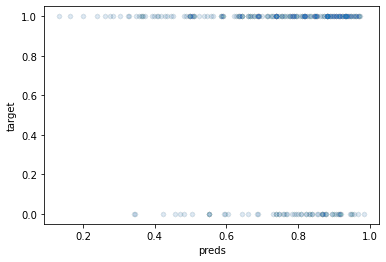

In [23]:
review_set = 'test' # 'test', 'train'

predictions = model.predict_proba(input_data[f'x_{review_set}'])[:,1]
# predictions = model.predict(input_data[f'x_{review_set}'])
# print(pd.Series(predictions).value_counts(normalize=True)[1])

input_data[review_set]['preds'] = predictions
test_results = input_data[review_set][['target','preds']].copy()
test_results['perc_target_stop'] = input_data[review_set]['perc_target_stop']

plot_preds = True
if plot_preds:
    # plot scatter of preds vs label
    test_results.plot.scatter(x='preds', y='target', alpha=0.01); plt.show()

C:\Users\Jameshuckle\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-----
test
Accuracy (manual calc): 0.623
Sharpe: -2.12


C:\Users\Jameshuckle\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-----
train
Accuracy (manual calc): 1.000
Sharpe: 30.06


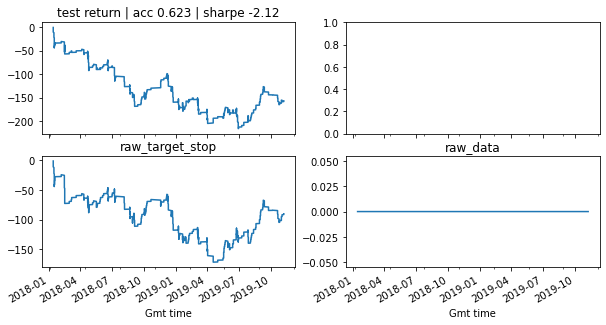

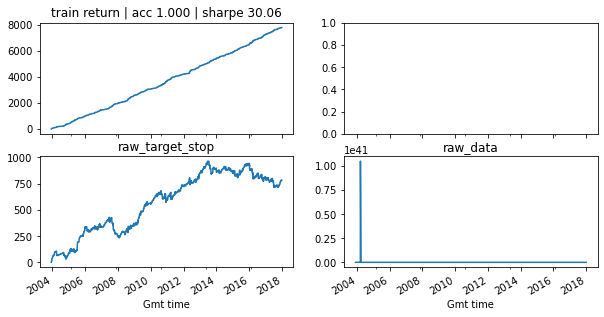

In [24]:
def calc_sharpe(returns, time_frame='1D', scale_returns=0.001):
    resample = False
    if time_frame in [None, False]:
        correction = np.sqrt(24*365)
    elif time_frame == '4H':
        correction = np.sqrt(6*365)        
    elif time_frame == '1D':
        correction = np.sqrt(365)
    elif time_frame == '1W':
        correction = np.sqrt(4)
    else:
        raise Exception(f'time_frame "{time_frame}" is not recognized!')
        
    col = returns.name
    returns = returns * scale_returns
    sharpe = (returns.mean() / returns.std()) * correction
    return sharpe


def calc_returns(test_results, review_set, label='target', close_diff_col='ohlc_diff_close', 
                 time_frame='1H'):
    fig, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 5))
    if var.problem_type == 'binary':
        test_results['binary_pred'] = (test_results['preds'] >= 0.5).astype(int)
        test_results['trade_map'] = test_results['binary_pred'].replace(0, -1)
    elif var.problem_type == 'category':
        test_results['binary_pred'] = test_results['preds']
        test_results['trade_map'] = test_results['preds'] - 1
    test_results['return'] = test_results['perc_target_stop'] * test_results['trade_map']
    test_results['correct'] = ((test_results[label] == test_results['binary_pred']).astype(int))
    acc = test_results['correct'].mean()
    sharpe = calc_sharpe(test_results['return'], time_frame, scale_returns=0.01)
    print('-----')
    print(review_set)
    print(f"Accuracy (manual calc): {acc:.3f}")
    print(f"Sharpe: {sharpe:.2f}")
    
    # plot charts     
    test_results['return'].cumsum().plot(
        title=f'{review_set} return | acc {acc:.3f} | sharpe {sharpe:.2f}', ax=ax[0,0])
    (input_data[review_set][close_diff_col] + 1).cumprod().plot(title='raw_data', ax=ax[1,1])
    test_results['perc_target_stop'].cumsum().plot(title='raw_target_stop', ax=ax[1,0])
    returns_plot = plt.gca()      
    return returns_plot, test_results, sharpe
    
class variables():
    None
var = variables()
var.resample = '1D'
var.problem_type = 'binary'

for review_set in ['test', 'train']:
#for review_set in ['test']:
    predictions = model.predict_proba(input_data[f'x_{review_set}'])[:,1]
    input_data[review_set]['preds'] = predictions
    test_results = input_data[review_set][['target','preds']].copy()
    test_results['perc_target_stop'] = input_data[review_set]['perc_target_stop']
    returns_plot, test_results, sharpe = calc_returns(test_results, review_set, label='target',
                                                      close_diff_col='perc_target_stop',
                                                      time_frame=var.resample)

In [25]:
def show_feature_importance(features, num):
    importances = dict(zip(features , model.feature_importances_))
    importances = pd.Series(importances)                                                                                                                                     
    importances = importances.sort_values(ascending=False)
    imp_features = importances.head(num)
    return imp_features

show_feature_importance(features, num=100)

830     0.012880
275     0.010147
1178    0.010089
35      0.010073
148     0.010004
714     0.009745
514     0.008602
951     0.008088
601     0.008010
28      0.007836
158     0.007812
667     0.007792
921     0.007494
686     0.007224
647     0.007199
769     0.006728
565     0.006720
544     0.006670
276     0.006586
979     0.006584
1075    0.006416
900     0.006392
375     0.006161
1141    0.006131
325     0.006016
348     0.005977
703     0.005732
991     0.005686
650     0.005612
410     0.005595
869     0.005579
487     0.005500
578     0.005495
738     0.005432
418     0.005336
1010    0.005330
1093    0.005135
324     0.005099
1195    0.005012
674     0.004978
357     0.004915
266     0.004891
721     0.004882
962     0.004862
476     0.004837
209     0.004800
887     0.004792
655     0.004779
786     0.004754
556     0.004727
832     0.004702
1003    0.004680
880     0.004637
1013    0.004478
1174    0.004432
1132    0.004416
949     0.004402
345     0.004377
785     0.0042